In [1]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch import Tensor
import torch.nn.functional as F
from torchvision import transforms
from einops import rearrange

from models.vit import ViT

In [2]:
IN_CHANNELS = 3
IMG_SIZE = 224
N_CLASSES = 1000
IMG_PATH = "./transformer_data/img.jpg"
IMAGENET_LABELS = dict(enumerate(open('./transformer_data/ilsvrc2012_wordnet_lemmas.txt')))

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

PATCH_SIZE = 16
EMB_SIZE = 768
DEPTH = 12
N_HEADS = 12
MLP_DIM = 4 * EMB_SIZE
ATTN_DROPOUT = 0.
MLP_DROPOUT = 0.1
WEIGHT_PATH = './transformer_data/vit_weights.pt'

In [3]:
vit = ViT(
    in_channels=IN_CHANNELS,
    patch_size=PATCH_SIZE,
    img_size=IMG_SIZE,
    n_classes=N_CLASSES,
    emb_size=EMB_SIZE,
    depth=DEPTH,
    n_heads=N_HEADS,
    mlp_dim=MLP_DIM,
    attn_dropout=ATTN_DROPOUT,
    mlp_dropout=MLP_DROPOUT
).to(DEVICE)

_ vit.load_state_dict(torch.load(WEIGHT_PATH))
vit.eval()

ViT(
  (embeddings): Embeddings(
    (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (ffn): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (attn): MultiHeadAttention(
          (q): Linear(in_features=768, out_features=768, bias=True)
          (k): Linear(in_features=768, out_features=768, bias=True)
          (v): Linear(in_features=768, out_features=768, bias=True)
          (out): Linear(in_features=768, out_features=768, bias=True)
        )
      )
      (1): EncoderBlock(
        (attn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_af

In [4]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open(IMG_PATH)
x = transform(im)

In [5]:
logits, attn_prob = vit(x.unsqueeze(0).to(DEVICE))

In [7]:
probs = F.softmax(logits, dim=-1)
top5 = torch.argsort(probs, dim=-1, descending=True)
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {IMAGENET_LABELS[idx.item()]}', end='')

0.58583 : Cardigan, Cardigan_Welsh_corgi
0.40226 : Pembroke, Pembroke_Welsh_corgi
0.00455 : dingo, warrigal, warragal, Canis_dingo
0.00064 : basenji
0.00049 : Border_collie


In [8]:
def attention_rollout(img: np.ndarray, attn_probs = [Tensor]) -> [np.ndarray]:
    # average attn probs across all heads
    attn = torch.stack(attn_probs).squeeze().mean(dim=1).cpu()
    
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    aug_attn = attn + torch.eye(attn.size(1))
    aug_attn = aug_attn / aug_attn.sum(dim=-1, keepdim=True)
    
    # Recursively multiply the weight matrices
    joint_attn = torch.zeros(aug_attn.size())
    joint_attn[0] = aug_attn[0]
    
    for i, a in enumerate(aug_attn[1:], 1):
        joint_attn[i] = a @ joint_attn[i-1]
    
    v = joint_attn[-1]
    grid_size = int(np.sqrt(aug_attn.size(-1)))
    resize = transforms.Resize(img.shape[1::-1])

    attn_overlays = np.zeros((joint_attn.size(0), *img.shape))
    for i, a in enumerate(joint_attn):
        mask = a[0, 1:].reshape(1, grid_size, grid_size).detach().numpy()[0]
        mask = cv2.resize(mask / mask.max(), img.shape[1::-1])
        mask = np.repeat(mask[:,:,np.newaxis], 3, axis=-1)

        attn_overlays[i] = (mask * img)
    return attn_overlays.astype(np.uint8)

def divisors(n):
    divs = [1]
    for i in range(2,int(np.sqrt(n))+1):
        if n%i == 0:
            divs.extend([i,n/i])
    divs.extend([n])
    return np.array(list(set(divs)))

def viz_attention_maps(attn_overlays: np.ndarray):
    divs = divisors(attn_overlays.shape[0])
    idx = np.argmin((divs[1:] - divs[:-1])[::-1])
    rows, cols = int(divs[idx]), int(divs[idx+1])
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(attn_overlays[i*cols+j])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            axs[i,j].set_title(f'Attention Map Layer {i*cols+j+1}/{attn_overlays.shape[0]}')
    plt.tight_layout()
    plt.show()

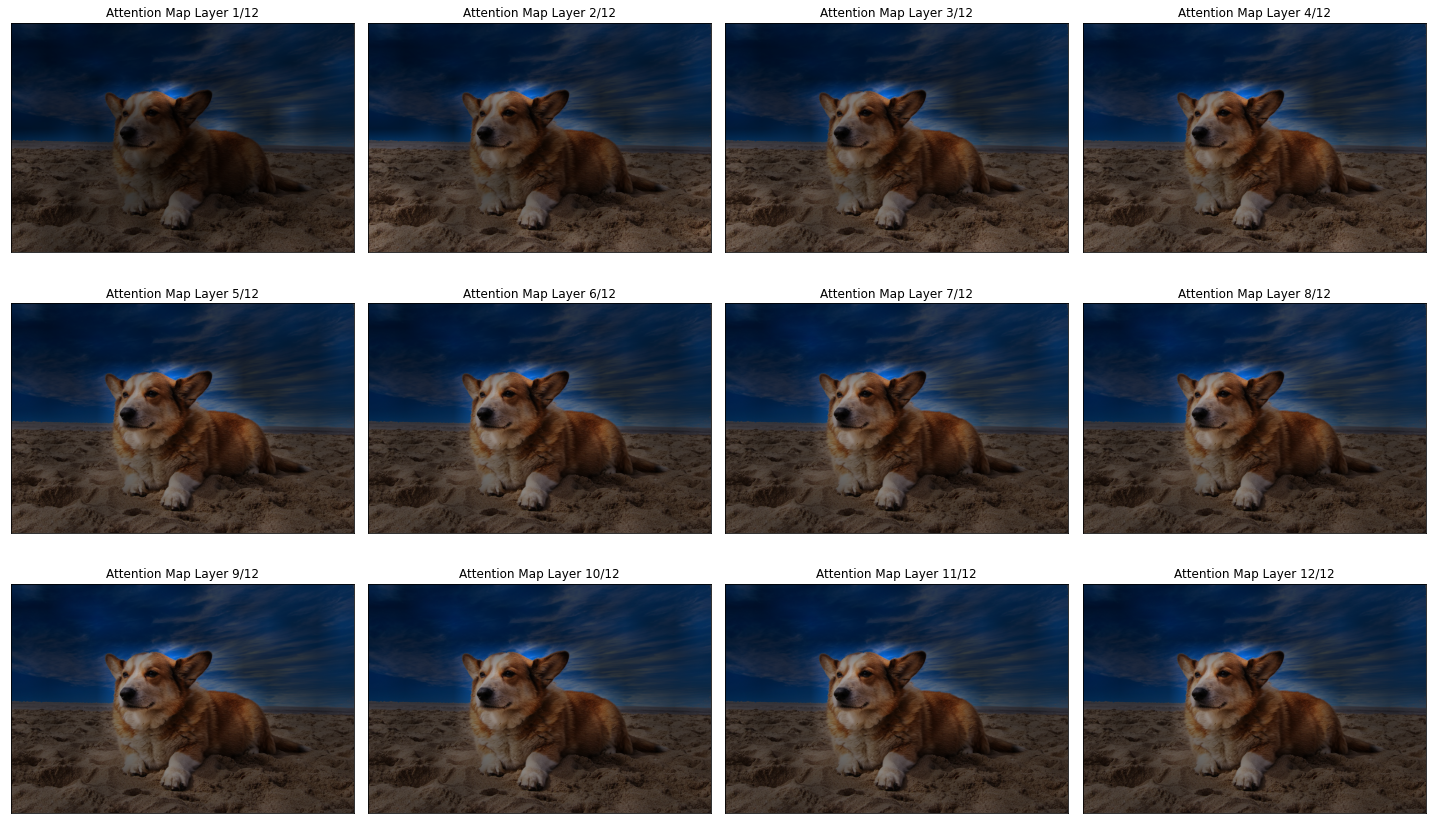

In [9]:
attn_overlays = attention_rollout(np.array(im), attn_prob)
viz_attention_maps(attn_overlays)